# LIDA - Automatic Generation of Visualizations and Infographics using Large Language Models

LIDA is a library for generating data visualizations and data-faithful infographics. LIDA is grammar agnostic (will work with any programming language and visualization libraries e.g. matplotlib, seaborn, altair, d3 etc) and works with multiple large language model providers (OpenAI, PaLM, Cohere, Huggingface). Details on the components of LIDA are described in the [paper here](https://arxiv.org/abs/2303.02927) and in this tutorial [notebook](notebooks/tutorial.ipynb). See the project page [here](https://microsoft.github.io/lida/) for updates!.



## Getting Started | Installation

```bash 
pip install lida
```

If you intend to use lida with local huggingface models, you will need to install the `transformers` library. 

```bash
pip install lida[transformers]
```

## The LIDA Python API

Lida offers a manager class that exposes core functionality of the LIDA system. This tutorial will show you how to use the manager class to create visualizations based on a dataset.

### Multiple LLM Backends
LIDA supports multiple LLM backends such as `openai`, `cohere`, `palm`, `huggingface` etc. You can switch between backends by setting the `text_gen` parameter in the `Manager` class. By default, LIDA uses the `openai` backend. For a list of supported models and how to configure them, see the [llmx documentation](https://github.com/victordibia/llmx).

```python

from lida import llm

text_gen = llm("openai") # for openai
text_gen = llm(provider="openai", api_type="azure", api_base=os.environ["AZURE_OPENAI_BASE"], api_key=os.environ["AZURE_OPENAI_API_KEY"],    api_version="2023-07-01-preview") # for azure openai
text_gen = llm("cohere") # for cohere
text_gen = llm("palm") # for palm
text_gen = llm(provider="hf", model="uukuguy/speechless-llama2-hermes-orca-platypus-13b", device_map="auto")

lida = Manager(text_gen=text_gen)
```

Note that you can set your llm keys as follows

```bash
export OPENAI_API_KEY=<your key>
export COHERE_API_KEY=<your key>
# for PaLM
export PALM_SERVICE_ACCOUNT_KEY_FILE=<path to gcp service account key file>
export PALM_PROJECT_ID=<your gcp project id>
```
#### Azure OpenAI
```python
from llmx.generators.text.openai_textgen import OpenAITextGenerator
from llmx.generators.text.textgen import sanitize_provider

provider = sanitize_provider("azureopenai")
models = {}

text_gen = OpenAITextGenerator(
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    api_base=os.environ["AZURE_OPENAI_BASE"],
    provider=provider,
    models=models
)
lida = Manager(text_gen=text_gen)
```


### Summarization Methods 
The summarizer module works takes an `summary_method` argument which determines if the base summary is enriched by an LLM. By default, the `summary_method` argument is set to `default` for a base summary (statistics etc). Set it to `llm` to enrich/annotate the base summary with an llm.

### Caching 
Each manager method takes a [`textgen_config`](https://github.com/victordibia/llmx/blob/7c0fc093d1b8780ebebc7e080f5c63991514038b/llmx/datamodel.py#L22C10-L22C10) argument which is a dictionary that can be used to configure the text generation process (with parameters for model, temperature, max_tokens, topk etc). One of the keys in this dictionary is `use_cache`. If set to `True`, the manager will cache the generated text associated with that method. Use for speedup and to avoid hitting API limits.


In [1]:
# !pip install lida 
# !pip install lida[infographics] # for infographics support

In [2]:
from lida import Manager, TextGenerationConfig , llm  

## Summarize Data, Generate Goals

In [3]:
lida = Manager(text_gen = llm("openai", api_key=None)) # !! api key
textgen_config = TextGenerationConfig(n=1, temperature=0.5, model="gpt-3.5-turbo-0301", use_cache=True)

summary = lida.summarize("https://raw.githubusercontent.com/uwdata/draco/master/data/cars.csv", summary_method="default", textgen_config=textgen_config)  
goals = lida.goals(summary, n=2, textgen_config=textgen_config)

for goal in goals:
    display(goal)


### Goal 0
---
**Question:** What is the relationship between engine size and horsepower?

**Visualization:** `Scatter plot of Engine_Size__l_ vs Horsepower_HP_`

**Rationale:** This visualization will help us understand if there is a correlation between engine size and horsepower. It will also help us identify any outliers or patterns in the data.



### Goal 1
---
**Question:** How does the retail price of cars vary by type?

**Visualization:** `Bar chart of Retail_Price by Type`

**Rationale:** This visualization will help us compare the average retail price of different types of cars. It will also help us identify any outliers or trends in the data. This information can be useful for car manufacturers and dealerships in setting prices for different types of cars.


In [33]:
# goals can also be based on a persona 
persona = "a mechanic who wants to buy a car that is cheap but has good gas mileage"
personal_goals = lida.goals(summary, n=2, persona=persona, textgen_config=textgen_config)
for goal in personal_goals:
    display(goal)


### Goal 0
---
**Question:** What is the distribution of Retail_Price and Dealer_Cost?

**Visualization:** `Side-by-side box plot of Retail_Price and Dealer_Cost`

**Rationale:** This visualization will help the mechanic to compare the distribution of Retail_Price and Dealer_Cost. It will show the median, quartiles, and outliers of the two variables. The mechanic can use this information to identify cars that are cheap but have good gas mileage.



### Goal 1
---
**Question:** What is the relationship between Engine_Size__l_ and City_Miles_Per_Gallon?

**Visualization:** `Scatter plot of Engine_Size__l_ and City_Miles_Per_Gallon`

**Rationale:** This visualization will help the mechanic to understand the relationship between Engine_Size__l_ and City_Miles_Per_Gallon. It will show if there is a positive or negative correlation between the two variables. The mechanic can use this information to identify cars with small engine sizes that have good gas mileage.


## Generate Visualizations

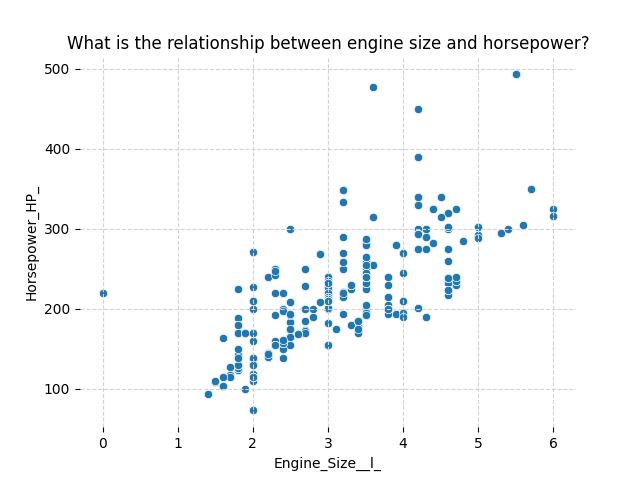

In [5]:
i = 0
library = "seaborn"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=goals[i], textgen_config=textgen_config, library=library)  
charts[0]

### Generate visualization via a "user query"   

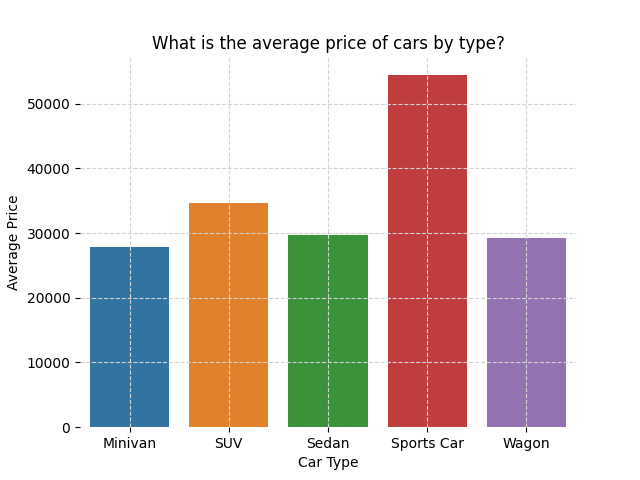

In [6]:
user_query = "What is the average price of cars by type?"
textgen_config = TextGenerationConfig(n=1, temperature=0.2, use_cache=True)
charts = lida.visualize(summary=summary, goal=user_query, textgen_config=textgen_config)  
charts[0]

# VizOps

Given that LIDA represents visualizations as code,
the VISGENERATOR also implements submodules
to perform operations on this representation. 

This includes 
- **Natural language based visualization refinement**: Provides a conversational api to iteratively
4Execution in a sandbox environment is recommended.
refine generated code (e.g., translate chart t hindi
. . . zoom in by 50% etc) which can then be executed to generate new visualizations.
- **Visualization explanations and accessibility**:
Generates natural language explanations (valuable
for debugging and sensemaking) as well as accessibility descriptions (valuable for supporting users
with visual impairments).

- **Visualization code self-evaluation and repair**:
Applies an LLM to self-evaluate generated code on
multiple dimensions (see section 4.1.2).

- **Visualization recommendation**: Given some context (goals, or an existing visualization), recommend additional visualizations to the user (e.g., for
comparison, or to provide additional perspectives).



## Natural language based visualization refinement 

Given some code, modify it based on natural language instructions. This yields a new code snippet that can be executed to generate a new visualization.

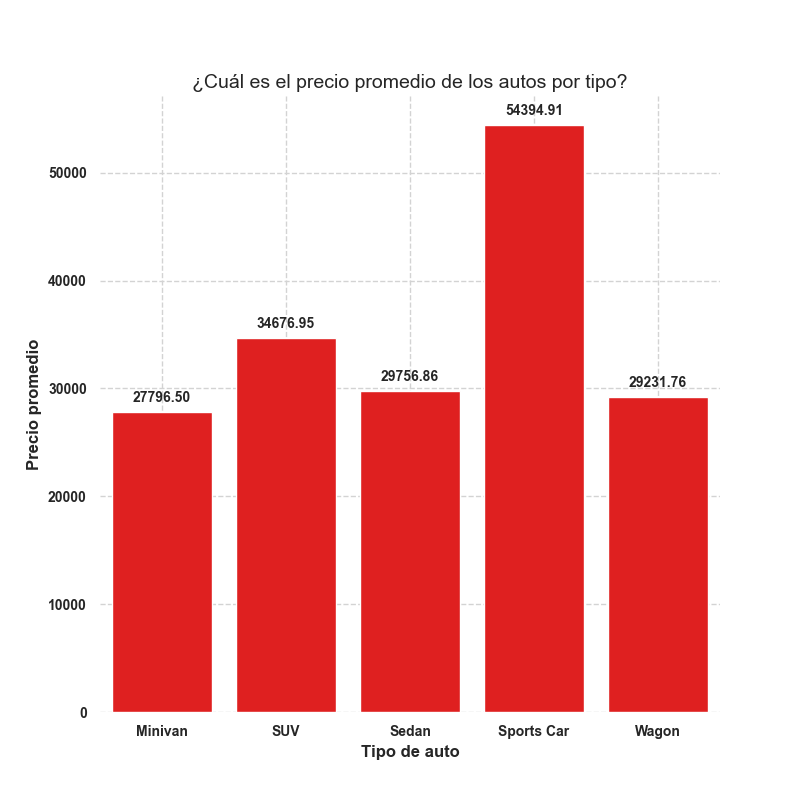

In [22]:
code = charts[0].code
textgen_config = TextGenerationConfig(n=1, temperature=0, use_cache=True)
instructions = ["make the chart height and width equal", "change the color of the chart to red", "translate the chart to spanish"]
edited_charts = lida.edit(code=code,  summary=summary, instructions=instructions, library=library, textgen_config=textgen_config)
edited_charts[0]

## Visualization explanations and accessibility

In [23]:
explanations = lida.explain(code=code, library=library, textgen_config=textgen_config) 
for row in explanations[0]:
    print(row["section"]," ** ", row["explanation"])

accessibility  **  The chart created by this code is a bar chart with the x-axis representing the different types of cars and the y-axis representing the average retail price of each car type. The chart is easy to read and understand, with clear labels for both axes and a title that summarizes the main question being answered by the chart. The colors used in the chart are the default colors used by seaborn, which are easy on the eyes and do not distract from the data being presented. The goal of the chart is to provide insights into the average prices of different types of cars, allowing the viewer to compare prices across different car types.
transformation  **  This section of the code applies a data transformation to the original dataset. Specifically, it groups the data by car type using the 'groupby' method and calculates the mean retail price for each car type using the 'mean' method. The resulting dataset is a new dataframe that contains two columns: 'Type' and 'Retail_Price', w

## Visualization code self-evaluation and repair

In [24]:
evaluations = lida.evaluate(code=code,  goal=goals[i], textgen_config=textgen_config, library=library)[0] 
for eval in evaluations:
    print(eval["dimension"], "Score" ,eval["score"], "/ 10")
    print("\t", eval["rationale"][:200])
    print("\t**********************************")

bugs Score 10 / 10
	 The code is free of bugs, syntax errors, and typos. It should compile without any issues.
	**********************************
transformation Score 8 / 10
	 The data is transformed appropriately by grouping the data by type and calculating the average price. However, the transformation is not appropriate for the specified goal of exploring the relationshi
	**********************************
compliance Score 3 / 10
	 The code does not meet the specified goal of exploring the relationship between engine size and horsepower. Instead, it visualizes the average price of cars by type.
	**********************************
type Score 2 / 10
	 The visualization type (bar chart) is not appropriate for exploring the relationship between engine size and horsepower. A scatter plot or line chart would be more effective.
	**********************************
encoding Score 7 / 10
	 The data is encoded appropriately by using the car type on the x-axis and the average price on the y-ax

## Visualization Recommendation

In [25]:
textgen_config = TextGenerationConfig(n=2, temperature=0.2, use_cache=True)
recommended_charts =  lida.recommend(code=code, summary=summary, n=2,  textgen_config=textgen_config)

Recommended 1 charts


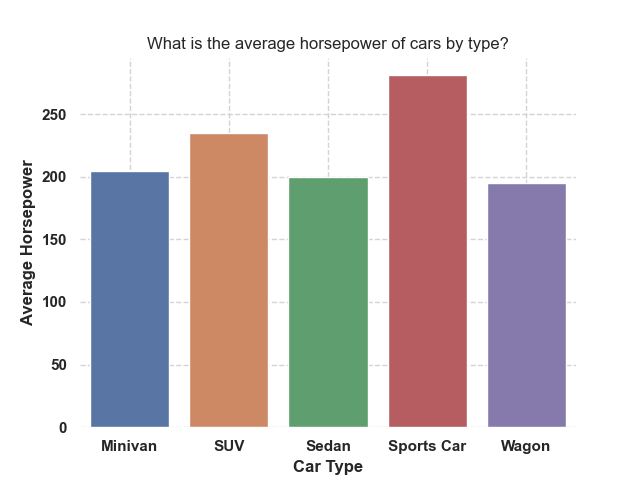

In [26]:
print(f"Recommended {len(recommended_charts)} charts")
for chart in recommended_charts:
    display(chart) 

## Infographics (Beta)

- Explores using LIDA to generate infographics from an existing visualization 
- Uses the `peacasso` package, and loads open source stable diffusion models 
- You will need to run `pip install lida[infographics]` to install the required dependencies.
- Currently work in progress (work being done to post process infographics with chart axis and title overlays from the original visualization, add presets for different infographic styles, and add more stable diffusion models)


In [27]:
# !pip install lida[infographics] 
# ensure you have a GPU runtime

In [ ]:
infographics = lida.infographics(visualization = edited_charts[0].raster, n=1, style_prompt="pastel art, green pearly rain drops, highly detailed, no blur, white background")

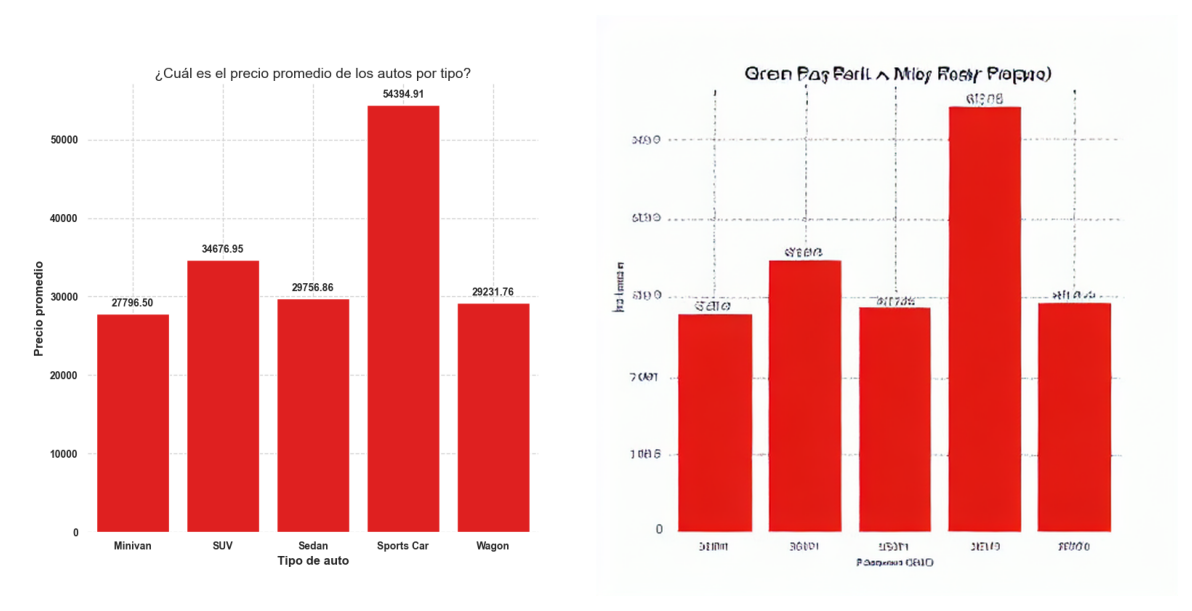

In [32]:
from lida.utils import plot_raster
plot_raster([edited_charts[0].raster, infographics["images"][0]]) 